In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
from pyne.material import Material

/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
import analysis as an

In [3]:
# metrics to get
# does it transition?
# pu inventory
# raffinate
# lwr unf reprocessed
# reprocessing throughput
# unreprocessed lwr amount

In [4]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [5]:
cur = an.get_cursor('./output/precise2.sqlite')
output_dict = metric_solver(cur)

NameError: name 'metric_solver' is not defined

In [ ]:
def metric_solver(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')
    
    # pu generated
    storage_id = an.get_agent_ids(cur, 'storage')
    rep_id = an.get_agent_ids(cur, 'separations')
    lwr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['uox_waste'], False, True)
    sfr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['sfr_used'], False, True)
    blanket = an.facility_commodity_flux(cur, storage_id, ['blanket_used'], False, True)
    legacy = an.facility_commodity_flux(cur, rep_id, ['pre_2013_unf'], False, True)
    if len(legacy['pre_2013_unf']) == 0:
        print('This one does not have legacy pu')
    pu_generated = ((lwr_pu * np.array(lwr_fuel_out['uox_waste'])) +
                    (np.array(sfr_fuel_out['sfr_used']) * sfr_used_pu) +
                    (np.array(blanket['blanket_used']) * blanket_used_pu))
    try:
        pu_generate += np.array(legacy['pre_2013_unf']) * legacy_pu
    except:
        print('I TOLD YOU NO LEGACY')

    # pu used
    mixer_id = an.get_agent_ids(cur, 'mixer')
    sfr_fuel_in = an.facility_commodity_flux(cur, mixer_id, ['sfr_fuel_new', 'sfr_fuel_legacy'], True, True)
    total_sfr_fuel_in = np.array(sfr_fuel_in['sfr_fuel_new']) + np.array(sfr_fuel_in['sfr_fuel_legacy'])
    pu_used = (total_sfr_fuel_in * sfr_pu)
    
    # lwr reprocessed
    legacy_sfr = np.array(sfr_fuel_in['sfr_fuel_legacy'])
    legacy_pu = legacy_sfr * sfr_pu
    legacy_lwr_reprocessed = legacy_pu / lwr_pu
    print('LEGACY LWR REPROCESSED: %f' %legacy_lwr_reprocessed[-1])
    output_dict['lwr UNF reprocessed'] = legacy_lwr_reprocessed[-1]
    
    # unreprocessed lwr amount
    lwr_amount = lwr_fuel_out['uox_waste'][-1]
    try:
        lwr_amount += legacy['pre_2013_unf'][-1]
    except:
        print('NO LEGACY')
    unreprocessed_lwr = lwr_amount - legacy_lwr_reprocessed[-1]
    print('UNREPROCESSED LWR: %f' %unreprocessed_lwr)
    output_dict['unreprocessed lwr'] = unreprocessed_lwr
    
    # sfr reprocessing throughput
    new_sfr = np.array(sfr_fuel_in['sfr_fuel_new'])
    new_sfr_reprocesed = new_sfr * sfr_pu / sfr_used_pu
    reprocessing_throughput = new_sfr_reprocesed + legacy_lwr_reprocessed
    print('SFR UNF REPROCESSED: %f' %new_sfr_reprocesed[-1])
    output_dict['sfr UNF reprocessed'] = new_sfr_reprocesed[-1]

    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux(cur, sink_id, ['reprocess_waste'], False, True)
    output_dict['raffinate'] = raffinate['reprocess_waste'][-1]
    print('RAFFINATE: %f' %raffinate['reprocess_waste'][-1])

    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)

    output_dict['decay heat'] = np.nansum(list(dict(z.decay_heat()).values()))
    output_dict['activity'] = np.nansum(list(dict(z.activity()).values()))
    print('decay heat: %f' %output_dict['decay heat'])
    print('activity: %f' %output_dict['activity'])

    # get them metrics
    pu_inventory = pu_generated - pu_used
    output_dict['pu inventory'] = pu_inventory[-1]
    print('PU INVENTORY: %f' %pu_inventory[-1])
    return output_dict

In [7]:
# get all output files
file_list = []
for root, dirs, files in os.walk('./output/sweep'):
    for file in files:
        if file.endswith('.sqlite'):
            file_list.append(os.path.join(root, file))
print(file_list)

['./output/sweep/2030_005_growth_no.sqlite', './output/sweep/2030_005_growth_precise.sqlite', './output/sweep/2030_005_growth_recipe.sqlite', './output/sweep/2030_015_growth_no.sqlite', './output/sweep/2030_015_growth_precise.sqlite', './output/sweep/2030_015_growth_recipe.sqlite', './output/sweep/2030_01_growth_no.sqlite', './output/sweep/2030_01_growth_precise.sqlite', './output/sweep/2030_01_growth_recipe.sqlite', './output/sweep/2030_0_growth_no.sqlite', './output/sweep/2030_0_growth_precise.sqlite', './output/sweep/2030_0_growth_recipe.sqlite', './output/sweep/2035_005_growth_no.sqlite', './output/sweep/2035_005_growth_precise.sqlite', './output/sweep/2035_005_growth_recipe.sqlite', './output/sweep/2035_015_growth_no.sqlite', './output/sweep/2035_015_growth_precise.sqlite', './output/sweep/2035_015_growth_recipe.sqlite', './output/sweep/2035_01_growth_no.sqlite', './output/sweep/2035_01_growth_precise.sqlite', './output/sweep/2035_01_growth_recipe.sqlite', './output/sweep/2035_0_g

In [8]:
# do work
f = open('./output/metrics', 'w')
for file in file_list:
    if file != file_list[0]:
        f = open('./output/metrics', 'a+')
    outputname = '%s' %(file.replace('./output/sweep/', '').replace('.sqlite', ''))
    print('DOING %s' %outputname)
    cur = an.get_cursor(file)
    an.plot_power(cur)
    os.rename('power_plot.png', './output/%s.png' %outputname)
    out_dict = metric_solver(cur)
    f.write('%s\n======================' %outputname)
    for key, val in out_dict.items():
        write_string = '%s:\t%s\ttons' %(key, str(val))
        f.write(write_string)
    f.write('\n')
    f.close()


DOING 2030_005_growth_no
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
This one does not have legacy pu
This one does not have legacy pu
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 123790.326064
NO LEGACY
UNREPROCESSED LWR: 10965.208936
SFR UNF REPROCESSED: 70422.084982
RAFFINATE: 8524.112647
decay heat: 0.000853
activity: 7434262579138033.000000
PU INVENTORY: 1112.960804
DOING 2030_005_growth_precise
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 134139.709306
UNREPROCESSED LWR: 68687.855694
SFR UNF REPROCESSED: 70412.630238
RAFFINATE: 9702.281119
decay heat: 15813846.594305
activity: 60321617157109000358068224.000000
PU INVENTORY: 1043.738232
DOING 2030_005_growth_recipe
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 134139.709306
UNREPROCESSED LWR: 68687.855694
SFR UNF

LEGACY LWR REPROCESSED: 74859.319779
NO LEGACY
UNREPROCESSED LWR: 68913.540221
SFR UNF REPROCESSED: 37049.990201
RAFFINATE: 5478.333785
decay heat: 0.000542
activity: 4570741901779794.000000
PU INVENTORY: 1403.531782
DOING 2035_0_growth_precise
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 74859.319779
UNREPROCESSED LWR: 136985.570221
SFR UNF REPROCESSED: 37049.990201
RAFFINATE: 6653.645292
decay heat: 15813846.594163
activity: 60321617155505259569741824.000000
PU INVENTORY: 1403.531782
DOING 2035_0_growth_recipe
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 74859.319779
UNREPROCESSED LWR: 136985.570221
SFR UNF REPROCESSED: 37049.990201
RAFFINATE: 6645.119854
decay heat: 12816681.394927
activity: 48890399522076063705333760.000000
PU INVENTORY: 1403.531782
DOING 2040_005_growth_no
blanket_inst has no values
Sink_S

blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 166760.380163
UNREPROCESSED LWR: 174490.514837
SFR UNF REPROCESSED: 42489.619589
RAFFINATE: 8928.842291
decay heat: 15813846.594636
activity: 60321617159124886208118784.000000
PU INVENTORY: 2386.111522
DOING 2045_01_growth_recipe
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 166760.380163
UNREPROCESSED LWR: 174490.514837
SFR UNF REPROCESSED: 42489.619589
RAFFINATE: 8920.316853
decay heat: 12816681.394772
activity: 48890399520861644522520576.000000
PU INVENTORY: 2386.111522
DOING 2045_0_growth_no
blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values
This one does not have legacy pu
This one does not have legacy pu
I TOLD YOU NO LEGACY
LEGACY LWR REPROCESSED: 42421.500217
NO LEGACY
UNREPROCESSED LWR: 169883.029783
SFR UNF REPROCESSED: 

In [11]:
with open('./output/prettier_metric', 'w') as w:
    with open('./output/metrics', 'r') as f:
        lines = f.readlines()
        for line in lines:
            if '======================' in line:
                line = line.replace('======================', '======================\n')
            if 'tons' in line:
                line = line.replace('tons', 'tons\n')
            w.write(line)


In [41]:
metric_dict = {}
with open('./output/prettier_metric', 'r') as f:
    lines = f.readlines()
    for indx,line in enumerate(lines):
        if 'growth' in line:
            z = line.split('_')
            key = str(z[0]) + '_' + str(z[1]) + '_' + str(z[-1]).replace('\n', '')
            metric_dict[key] = {'lwr unf reprocessed': lines[indx + 2],
                                'unreprocessed lwr': lines[indx + 3],
                                'sfr unf reprocessed': lines[indx + 4],
                                'raffinate': lines[indx + 5],
                                'decay heat': lines[indx + 6],
                                'activity': lines[indx + 7],
                                'pu inventory': lines[indx + 8]}
            for metric, val in metric_dict[key].items():
                metric_dict[key][metric] = float(val.split()[-2])
            metric_dict[key]['available year'] =  int(z[0])
            metric_dict[key]['growth rate'] = int(z[1]) / 100    
print(metric_dict)

    

{'2030_005_no': {'lwr unf reprocessed': 123790.32606368864, 'unreprocessed lwr': 10965.208936311363, 'sfr unf reprocessed': 70422.08498165957, 'raffinate': 8524.112647341568, 'decay heat': 0.0008527749976111552, 'activity': 7434262579138033.0, 'pu inventory': 1112.9608039932318, 'available year': 2030, 'growth rate': 0.05}, '2030_005_precise': {'lwr unf reprocessed': 134139.70930623633, 'unreprocessed lwr': 68687.85569376367, 'sfr unf reprocessed': 70412.6302376477, 'raffinate': 9702.281118651397, 'decay heat': 15813846.594305042, 'activity': 6.0321617157109e+25, 'pu inventory': 1043.7382318290292, 'available year': 2030, 'growth rate': 0.05}, '2030_005_recipe': {'lwr unf reprocessed': 134139.70930623633, 'unreprocessed lwr': 68687.85569376367, 'sfr unf reprocessed': 70412.6302376477, 'raffinate': 9693.755680550434, 'decay heat': 12816681.39483176, 'activity': 4.889039952184586e+25, 'pu inventory': 1043.7382318290292, 'available year': 2030, 'growth rate': 0.05}, '2030_015_no': {'lwr u

In [42]:
print(list(metric_dict.keys()))
print(list(metric_dict['2030_005_no'].keys()))

['2030_005_no', '2030_005_precise', '2030_005_recipe', '2030_015_no', '2030_015_precise', '2030_015_recipe', '2030_01_no', '2030_01_precise', '2030_01_recipe', '2030_0_no', '2030_0_precise', '2030_0_recipe', '2035_005_no', '2035_005_precise', '2035_005_recipe', '2035_015_no', '2035_015_precise', '2035_015_recipe', '2035_01_no', '2035_01_precise', '2035_01_recipe', '2035_0_no', '2035_0_precise', '2035_0_recipe', '2040_005_no', '2040_005_precise', '2040_005_recipe', '2040_015_no', '2040_015_precise', '2040_015_recipe', '2040_01_no', '2040_01_precise', '2040_01_recipe', '2040_0_no', '2040_0_precise', '2040_0_recipe', '2045_005_no', '2045_005_precise', '2045_005_recipe', '2045_015_no', '2045_015_precise', '2045_015_recipe', '2045_01_no', '2045_01_precise', '2045_01_recipe', '2045_0_no', '2045_0_precise', '2045_0_recipe', '2050_005_no', '2050_005_precise', '2050_005_recipe', '2050_015_no', '2050_015_precise', '2050_015_recipe', '2050_01_no', '2050_01_precise', '2050_01_recipe', '2050_0_no',

In [43]:
import seaborn as sns

In [45]:
import pandas as pd

9


In [49]:
metrics = pd.DataFrame.from_dict(data=metric_dict, orient='index')
metrics.head()
print(metrics)

                  lwr unf reprocessed  unreprocessed lwr  sfr unf reprocessed  \
2030_005_no             123790.326064       10965.208936         70422.084982   
2030_005_precise        134139.709306       68687.855694         70412.630238   
2030_005_recipe         134139.709306       68687.855694         70412.630238   
2030_015_no             155131.037862       12530.342138        112111.202911   
2030_015_precise        218214.734305       17518.675695        140484.889691   
2030_015_recipe         217446.758870       18286.651130        140283.188485   
2030_01_no              138710.991657       11713.993343         94957.145692   
2030_01_precise         201831.258359       16665.756641        103085.073961   
2030_01_recipe          201063.282924       17433.732076        103085.073961   
2030_0_no                82319.652576       36766.432424         49035.454027   
2030_0_precise           82319.652576      104838.462424         49035.454027   
2030_0_recipe            823

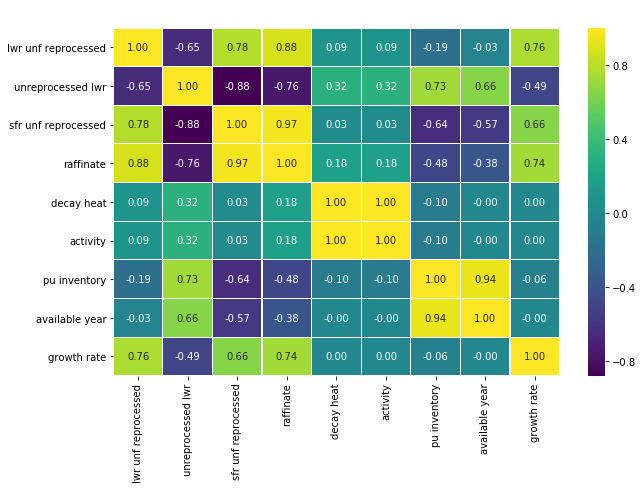